# Gini Coefficient Analysis
This notebook runs the appropriate data manipulations for comparing the Gini coefficients of QB's passing angles. Related visualizations are also included.

## Import data and functions

In [1]:
# import functions
from functions import (
    gini_coefficient,
    get_tracking_data,
    calc_angle,
    draw_table_image,
    BboxLocator
)

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
from highlight_text import fig_text, ax_text
from matplotlib.transforms import Bbox
import nfl_data_py as nfl

In [2]:
# get tracking receivers
angle_df = get_tracking_data()

# filter out nan rec_x values and for QB rows
angle_df = angle_df[(~angle_df["rec_x"].isnull()) &
                    (angle_df["officialPosition"] == "QB")]

## Calculate Angles and Cut into Buckets

In [3]:
# calculate angles
angle_df["angle"] = angle_df.apply(lambda x: calc_angle(x["rec_x"], x["rec_y"],
                                                        x["x"], x["y"]), axis=1)

# create bucket of angles
bins = [-np.inf, -135, -90, -45, 0, 45, 90, 135, np.inf]
labels = ['-180 to -135', '-135 to -90', '-90 to -45',
          '-45 to 0', '0 to 45', '45 to 90', '90 to 135', '135 to 180']
angle_df['angle_bucket'] = pd.cut(angle_df['angle'], bins=bins, labels=labels)

## Gini - Incomplete Only
Calculate the Gini coefficient for each QB's incomplete passes.

In [4]:
# group by nflId and angle bucket
inc_passes = angle_df[angle_df["passResult"] == "I"]
inc_passes = (
    inc_passes.groupby(["nflId", "angle_bucket"]).size().reset_index(name="count")
)
inc_passes["total"] = inc_passes.groupby("nflId")["count"].transform("sum")
inc_passes["count"] = inc_passes["count"] / inc_passes["total"]

# filter for threshold
inc_passes = inc_passes[inc_passes["total"] >= 25]

# pivot table
inc_passes = inc_passes.pivot(
    index="nflId", columns="angle_bucket", values="count"
).reset_index()

# gini coefficient
inc_passes["gini"] = inc_passes.apply(lambda x: gini_coefficient(x[1:]), axis=1)

## Gini - Complete Only
Calculate the Gini coefficient for each QB's completed passes.

In [5]:
# group by nflId and angle bucket
comp_passes = angle_df[angle_df["passResult"] == "C"]
comp_passes = (
    comp_passes.groupby(["nflId", "angle_bucket"]).size().reset_index(name="count")
)
comp_passes["total"] = comp_passes.groupby("nflId")["count"].transform("sum")
comp_passes["count"] = comp_passes["count"] / comp_passes["total"]

# filter for threshold
comp_passes = comp_passes[comp_passes["total"] >= 25]

# pivot table
comp_passes = comp_passes.pivot(
    index="nflId", columns="angle_bucket", values="count"
).reset_index()

# gini coefficient
comp_passes["gini"] = comp_passes.apply(lambda x: gini_coefficient(x[1:]), axis=1)

### Histrogram of Gini Coefficients on Completed Passes
Visualize the distribution of Gini coefficients on each QB's completed passes.

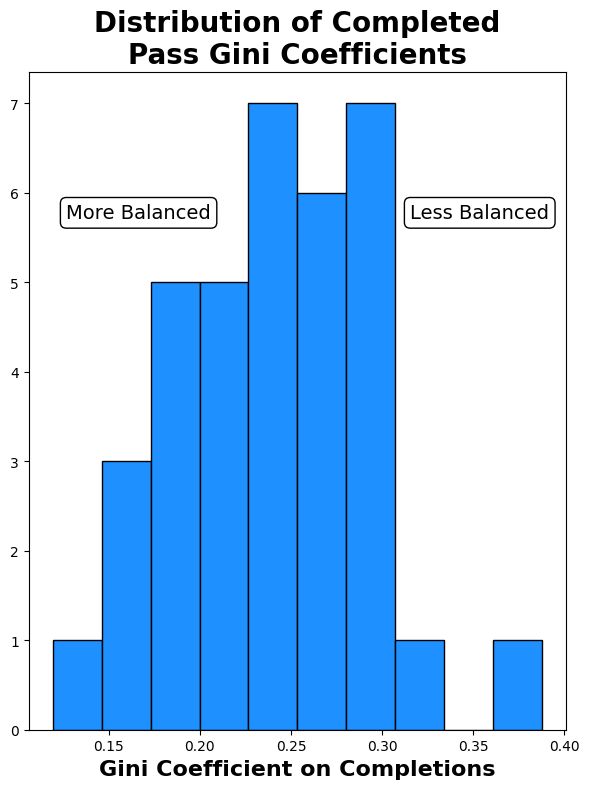

In [6]:
# make histrogram of completion gini
fig, ax = plt.subplots(figsize=(6, 8))

# plot histogram
ax.hist(comp_passes["gini"], bins=10, color="dodgerblue", edgecolor="black")

# title and axis labels
ax.set_title("Distribution of Completed\nPass Gini Coefficients", fontsize=20, fontweight="bold")
ax.set_xlabel("Gini Coefficient on Completions", fontsize=16, fontweight="bold")

# add text annotation
ax.text(0.07, .8, "More Balanced", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=1))

ax.text(0.71, .8, "Less Balanced", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=1))

# save and show figure
plt.tight_layout()
plt.savefig("figures/completion_gini.png", dpi=300)


## Gini Differences
Create dataframe of Gini differences between each QB's complete and incomplete passes.

In [7]:
# compare differences
diff_df = pd.merge(inc_passes, comp_passes, on="nflId", suffixes=("_all", "_comp"))
diff_df["gini_diff"] = diff_df["gini_all"] - diff_df["gini_comp"]

# join names back
qb_names = angle_df[["nflId", "displayName"]].drop_duplicates()
diff_df = pd.merge(diff_df, qb_names, on="nflId")[
    ["nflId", "displayName", "gini_all", "gini_comp", "gini_diff"]
]

# sort by gini diff
diff_df = diff_df.sort_values("gini_diff", ascending=True)

### Diverging Bars
Visualize the Gini differences between each QB's complete and incomplete passes.

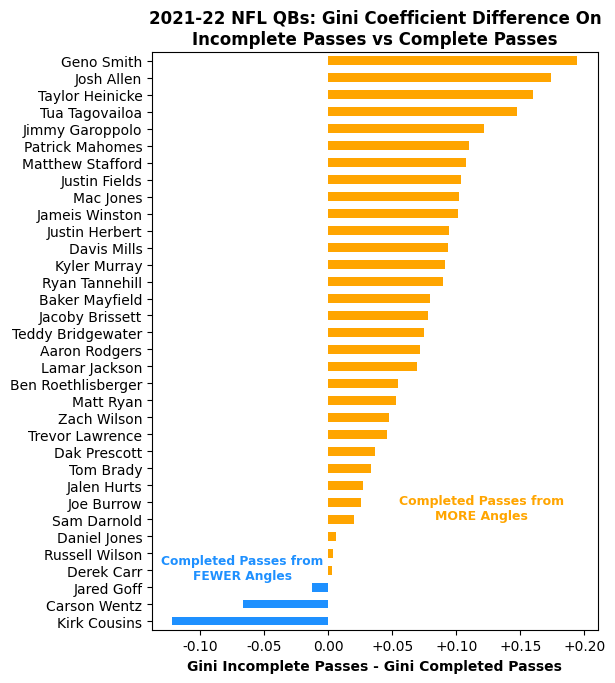

In [8]:
# horizontal bar chart of gini_diff
diff_df.plot.barh(
    x="displayName", y="gini_diff", figsize=(5.75, 7.5), legend=False,
    color=np.where(diff_df["gini_diff"] > 0, 'orange', 'dodgerblue')
)

# change axis titles
plt.xlabel("Gini Incomplete Passes - Gini Completed Passes", fontweight="bold")
plt.ylabel("")
plt.title("2021-22 NFL QBs: Gini Coefficient Difference On\nIncomplete Passes vs Complete Passes", fontweight="bold")

# add annotations
plt.text(0.12, 6, "Completed Passes from\nMORE Angles", fontsize=9, color = "orange", fontweight="bold", ha="center")
plt.text(-0.067, 2.5, "Completed Passes from\nFEWER Angles", fontsize=8.8, color = "dodgerblue", fontweight="bold", ha="center")

# add + to x-axis if > 0
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"+{x:.2f}" if x > 0 else f"{x:.2f}"))

# save plot
plt.savefig(
	"figures/diverging_bars.png",
	dpi = 600,
	bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
	transparent = False
)

plt.show()

## Scatter Plot of Total Completed Passes and Completed Gini

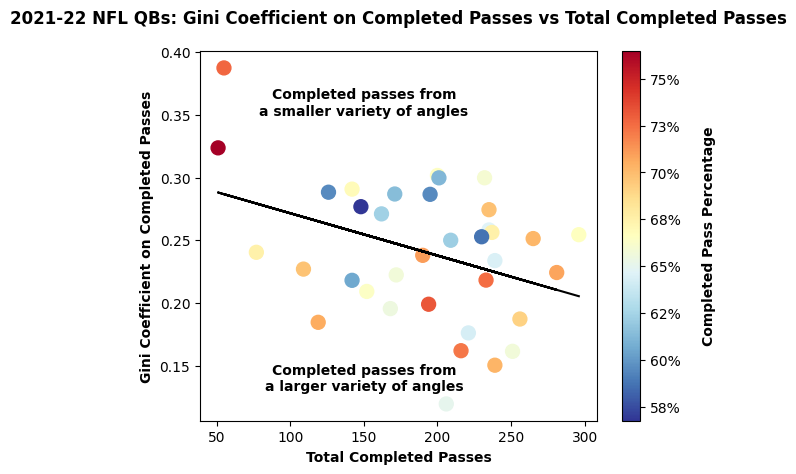

In [9]:
# group by nflId and see what proportion of rows are completed passes
total_comp = angle_df.groupby(["nflId", "passResult"]).size().reset_index(name="value")
total_comp["total"] = total_comp.groupby("nflId")["value"].transform("sum")
total_comp["value"] = total_comp["value"] / total_comp["total"]
total_comp = total_comp[total_comp["passResult"] == "C"].rename(
    columns={"value": "comp_pct"}
)[["nflId", "comp_pct", "total"]]

# join to diff_df
scatter_df = pd.merge(comp_passes, total_comp, on="nflId")

# create reversed colormap
cmap_reversed = cm.get_cmap("RdYlBu").reversed()

# Create a scatter plot using Matplotlib
sc = plt.scatter(
    scatter_df["total"],
    scatter_df["gini"],
    c=scatter_df["comp_pct"],
    cmap=cmap_reversed,
    s=100,
)

# increase fig size
plt.rcParams["figure.figsize"] = (10, 7)

# add title and axis titles
plt.title(
    "2021-22 NFL QBs: Gini Coefficient on Completed Passes vs Total Completed Passes",
    fontweight="bold",
    pad=20,
)
plt.xlabel("Total Completed Passes", fontweight="bold")
plt.ylabel("Gini Coefficient on Completed Passes", fontweight="bold")

# only show two decimal places on y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.2f}"))

# Add a colorbar with percentage labels
cbar = plt.colorbar(sc, format=ticker.PercentFormatter(xmax=1, decimals=0))

# change colorbar title
cbar.ax.set_ylabel("Completed Pass Percentage", labelpad=15, fontweight="bold")

# draw line of best fit
z = np.polyfit(scatter_df["total"], scatter_df["gini"], 1)
p = np.poly1d(z)
plt.plot(scatter_df["total"], p(scatter_df["total"]), color="black")

# add annotations
plt.text(
    150,
    0.13,
    "Completed passes from\na larger variety of angles",
    fontsize=10,
    color="black",
    fontweight="bold",
    ha="center",
)
plt.text(
    150,
    0.35,
    "Completed passes from\na smaller variety of angles",
    fontsize=10,
    color="black",
    fontweight="bold",
    ha="center",
)

# save
plt.savefig(
    "figures/scatter_gini.png",
    dpi=600,
    bbox_inches="tight",
    edgecolor="none",
    transparent=False,
    facecolor="white",
)

## Leaderboards

### Prep Data

In [17]:
# cols to select for external headshot
meta_cols = ["gsis_it_id", "headshot", "team_abbr"]

# get player headshot urls and teams
player_meta = nfl.import_players()[meta_cols].rename(
    columns={"gsis_it_id": "nflId"}
).sort_values(
    "team_abbr"
).drop_duplicates(
    "nflId", keep="first"
)

# filter out nan headshots and nflIds
player_meta = player_meta[~player_meta["headshot"].isna()]
player_meta = player_meta[~player_meta["nflId"].isna()]

# get team logos
logo_cols = ["team_abbr", "team_logo_espn"]

# get team logos
team_logos = nfl.import_team_desc()[logo_cols]

In [18]:
# create table data
table_dat = pd.merge(
    scatter_df[["nflId", "gini", "total"]],
    player_meta,
    on="nflId"
).merge(
    team_logos,
    on="team_abbr"
).merge(
    qb_names,
    on="nflId"
)

# filter for >= 100 total
table_dat = table_dat[table_dat["total"] >= 100]

# columns to take
table_cols = ["team_logo_espn", "headshot" ,"displayName", "total", "gini"]

# take top 10 balanced
balanced_data = table_dat.sort_values(
    "gini", ascending=True
).head(10)[table_cols].sort_values(
    # resort for table
    "gini", 
    ascending=False
)

# turn total into string
balanced_data["total"] = balanced_data["total"].astype(str)

# do same for least balanced
unbalanced_data = table_dat.sort_values(
    "gini", ascending=False
).head(10)[table_cols].sort_values(
    # resort for table
    "gini",
    ascending=True
)

# turn total into string
unbalanced_data["total"] = unbalanced_data["total"].astype(str)

### Most Balanced Leaderboard

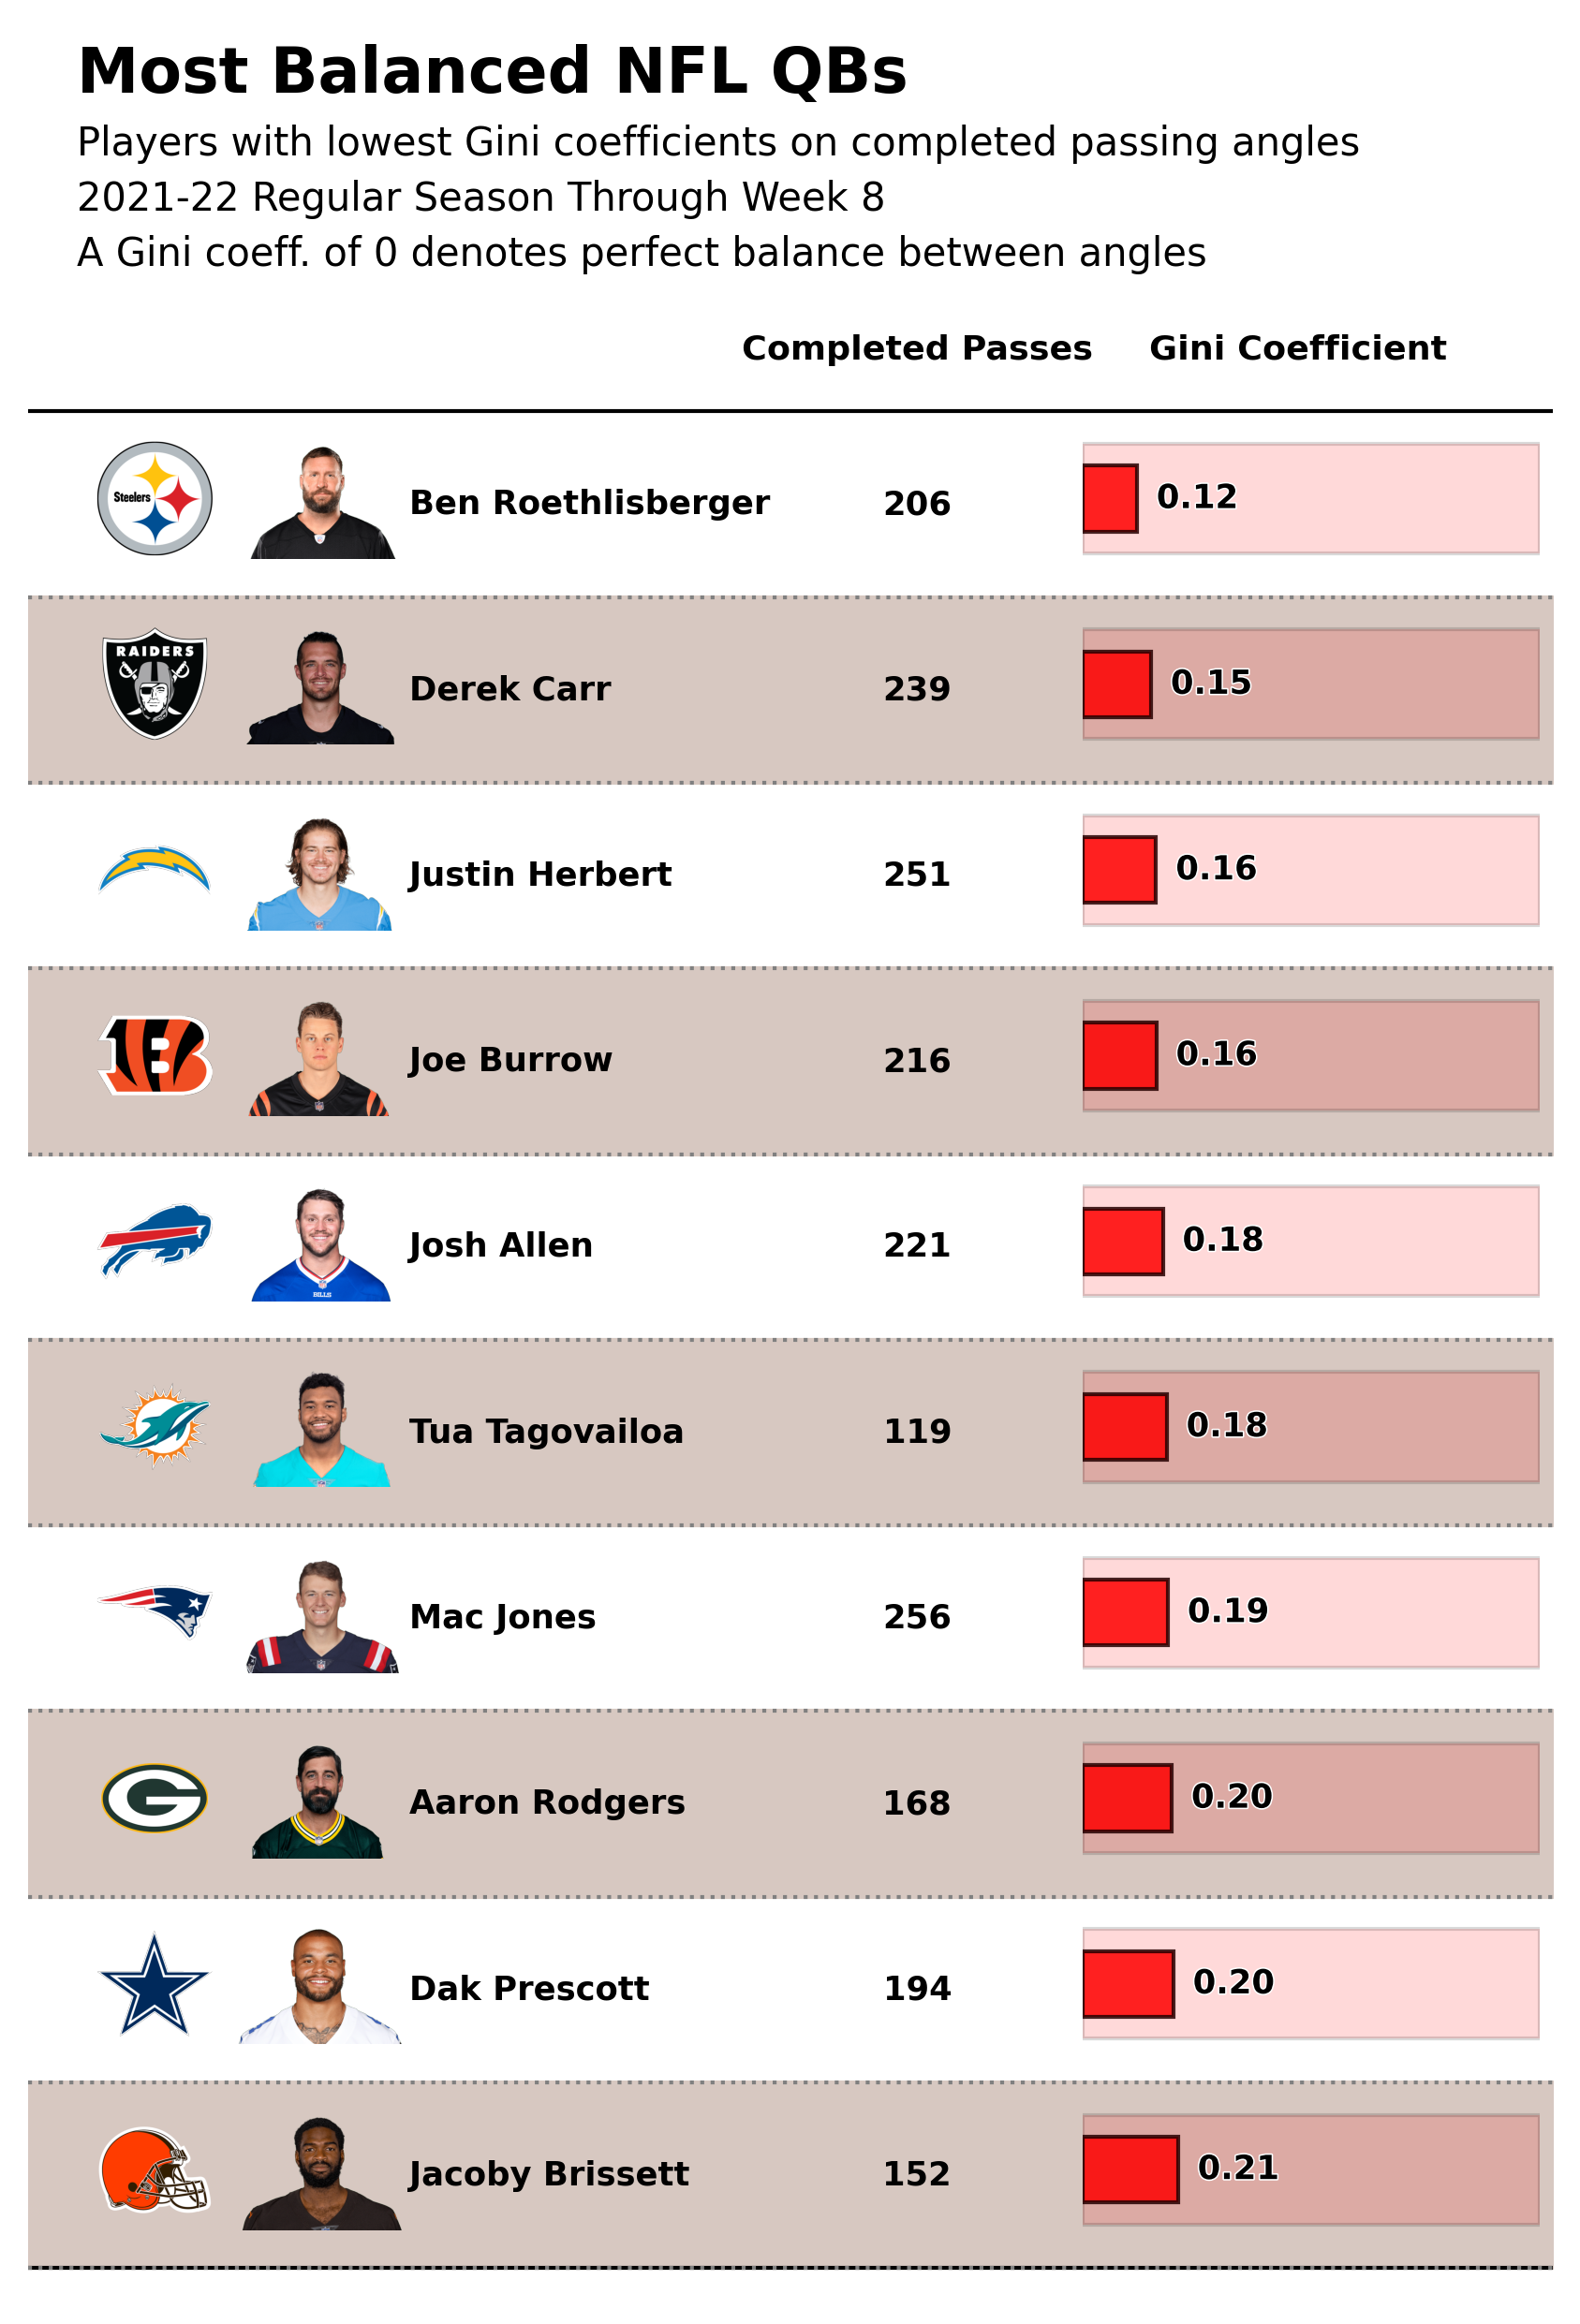

In [19]:
# concept from https://www.sonofacorner.com/whos-attempting-the-most-crosses-in-the-premier-league/

fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()

nrows = balanced_data.shape[0]
ncols = balanced_data.shape[1]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(-.65, nrows + 1)

# calculate asymmetry of x and y axes
x0, y0 = ax.transAxes.transform((0, 0)) # lower left in pixels
x1, y1 = ax.transAxes.transform((1, 1)) # upper right in pixes
dx = x1 - x0
dy = y1 - y0
maxd = max(dx, dy)
width = .5 * maxd / dx
height = .85 * maxd / dy

# Iterate
for y in range(0, nrows):
    # -- Team logo
    bbox = Bbox.from_bounds(0, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_table_image(balanced_data['team_logo_espn'].iloc[y], logo_ax)

    # -- Player headshot
    bbox = Bbox.from_bounds(.65, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_table_image(balanced_data['headshot'].iloc[y], logo_ax)
    # -- Player name
    ax_text(
        x=1.5, y=y,
        s=balanced_data['displayName'].iloc[y],
        weight='bold', size=8.5,
        ha='left', va='center', ax=ax
    )

    # -- Total completions
    ax_text(
        x=3.5, y=y,
        s=balanced_data['total'].iloc[y],
        size=8.5,
        ha='center', va='center', ax=ax,
        weight='bold'
    )

    # -- Battery Chart
    bbox = Bbox.from_bounds(4.15, y - .295, 1.8, .65)
    battery_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    battery_ax.set_xlim(0,1)
    battery_ax.barh(y=.5, width=balanced_data['gini'].iloc[y], height=.3, alpha=.85, color= "red", ec="black")
    battery_ax.barh(y=.5, width=1, height=.5, alpha=.15, color='red', ec='black')
    text_ = battery_ax.annotate(
        xy=(balanced_data['gini'].iloc[y], .5),
        xytext=(5,0),
        textcoords='offset points',
        # round text to 2 decimals with format
        text=f"{balanced_data['gini'].iloc[y]:.2f}",
        ha='left', va='center',
        size=8.5, weight='bold'
    )
    text_.set_path_effects(
                [path_effects.Stroke(linewidth=.75, foreground="white"), 
                path_effects.Normal()]
            )
    battery_ax.set_axis_off()

# -- Draw border lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows - .5, nrows - .5], lw=1, color='black', zorder=3)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-.5, -.5], lw=1, color='black', zorder=3)
for x in range(nrows):
    if x % 2 == 0:
        ax.fill_between(x=[ax.get_xlim()[0], ax.get_xlim()[1]], y1=x-.5, y2=x+.5, color='#d7c8c1', zorder=-1)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x - .5, x - .5], lw=1, color='grey', ls=':', zorder=3)

ax.set_axis_off()

# -- Column titles
ax_text(
    x=3.5, y=nrows-.25,
    s='Completed Passes',
    size=8.75,
    ha='center', va='bottom', ax=ax,
    textalign='center', weight='bold'
)
ax_text(
    x=5, y=nrows-.25,
    s='Gini Coefficient',
    size=8.75,
    ha='center', va='bottom', ax=ax,
    textalign='center', weight='bold'
)

fig_text(
    x = 0.15, y = .89, 
    s = "Most Balanced NFL QBs",
    va = "bottom", ha = "left",
    fontsize = 16, color = "black", weight = "bold"
)
fig_text(
	x = 0.15, y = .83, 
    s = "Players with lowest Gini coefficients on completed passing angles\n2021-22 Regular Season Through Week 8\nA Gini coeff. of 0 denotes perfect balance between angles",
	va = "bottom", ha = "left",
	fontsize = 10, color = "black", 
)

plt.savefig(
	"figures/balanced_leaderboard.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

### Least Balanced Leaderboard

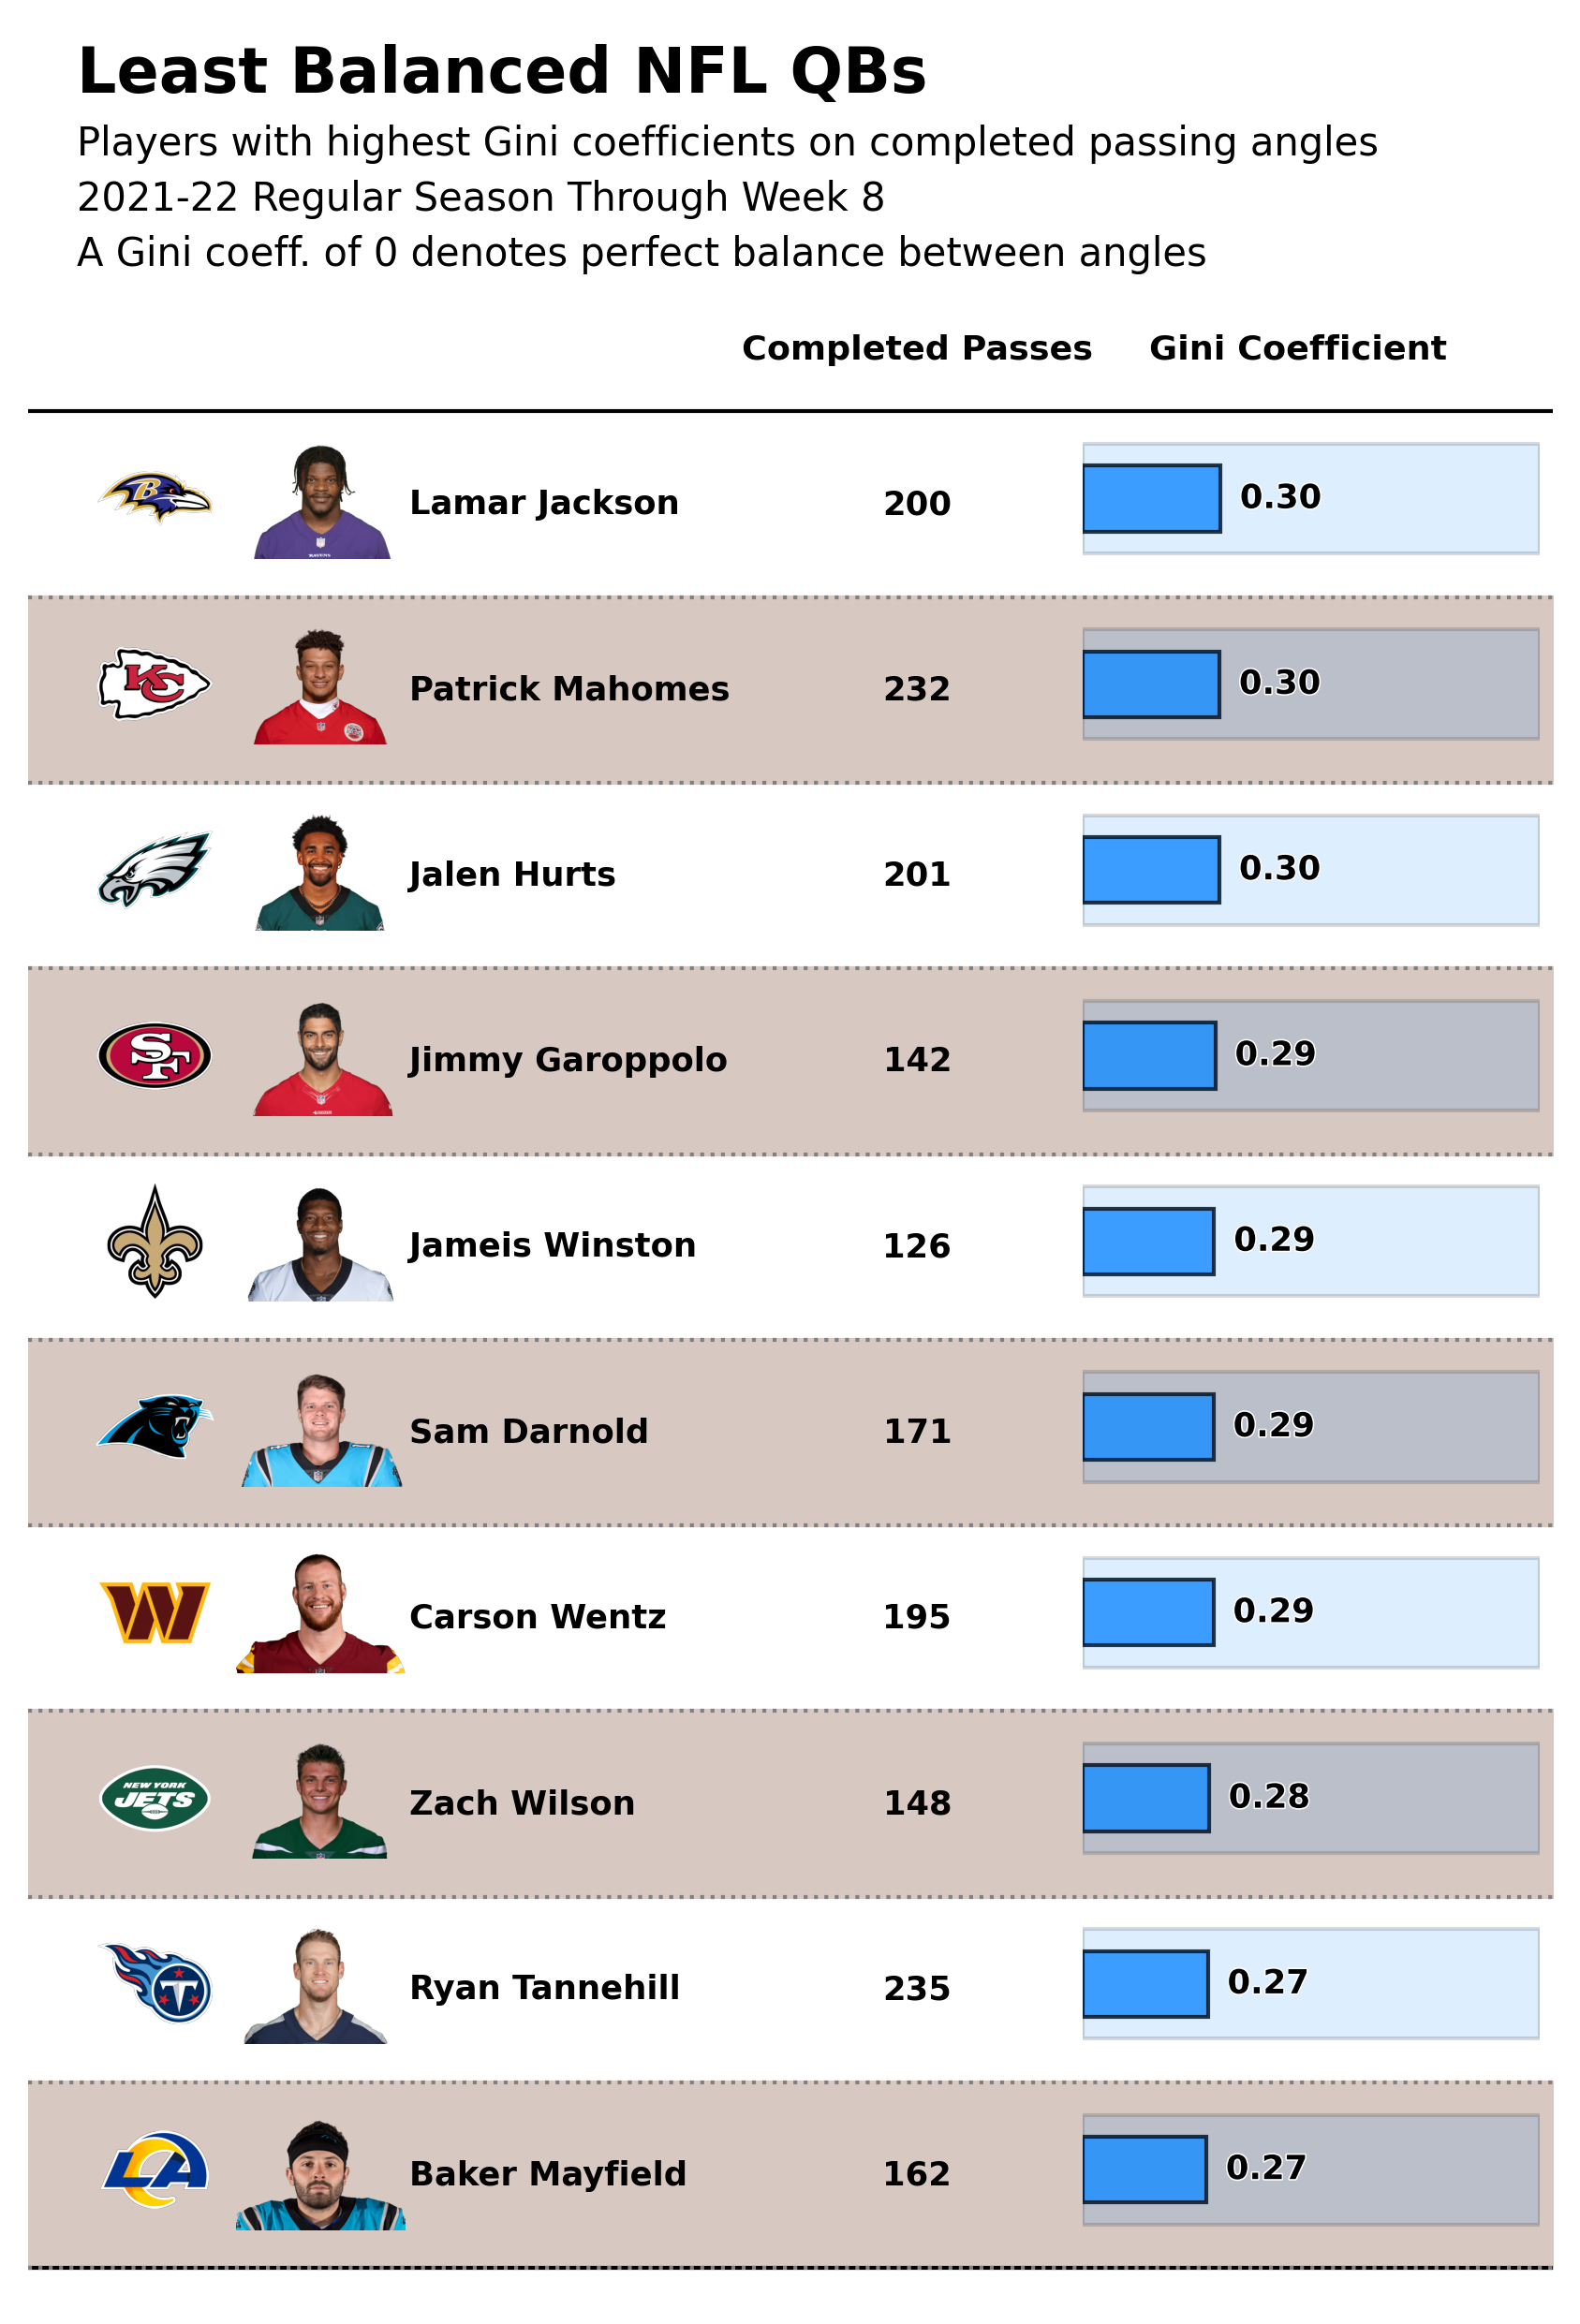

In [20]:
# concept from https://www.sonofacorner.com/whos-attempting-the-most-crosses-in-the-premier-league/

fig = plt.figure(figsize=(7, 10), dpi=300)
ax = plt.subplot()

nrows = unbalanced_data.shape[0]
ncols = unbalanced_data.shape[1]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(-0.65, nrows + 1)

# calculate asymmetry of x and y axes
x0, y0 = ax.transAxes.transform((0, 0))  # lower left in pixels
x1, y1 = ax.transAxes.transform((1, 1))  # upper right in pixes
dx = x1 - x0
dy = y1 - y0
maxd = max(dx, dy)
width = 0.5 * maxd / dx
height = 0.85 * maxd / dy

# Iterate
for y in range(0, nrows):
    # -- Team logo
    bbox = Bbox.from_bounds(0, y - 0.295, 1, 0.65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_table_image(unbalanced_data["team_logo_espn"].iloc[y], logo_ax)

    # -- Player headshot
    bbox = Bbox.from_bounds(0.65, y - 0.295, 1, 0.65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_table_image(unbalanced_data["headshot"].iloc[y], logo_ax)
    # -- Player name
    ax_text(
        x=1.5,
        y=y,
        s=unbalanced_data["displayName"].iloc[y],
        weight="bold",
        size=8.5,
        ha="left",
        va="center",
        ax=ax,
    )

    # -- Total completions
    ax_text(
        x=3.5,
        y=y,
        s=unbalanced_data["total"].iloc[y],
        size=8.5,
        ha="center",
        va="center",
        ax=ax,
        weight="bold",
    )

    # -- Battery Chart
    bbox = Bbox.from_bounds(4.15, y - 0.295, 1.8, 0.65)
    battery_ax = fig.add_axes(
        [0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData)
    )
    battery_ax.set_xlim(0, 1)
    battery_ax.barh(
        y=0.5,
        width=unbalanced_data["gini"].iloc[y],
        height=0.3,
        alpha=0.85,
        color="dodgerblue",
        ec="black",
    )
    battery_ax.barh(
        y=0.5, width=1, height=0.5, alpha=0.15, color="dodgerblue", ec="black"
    )
    text_ = battery_ax.annotate(
        xy=(unbalanced_data["gini"].iloc[y], 0.5),
        xytext=(5, 0),
        textcoords="offset points",
        # round text to 2 decimals with format
        text=f"{unbalanced_data['gini'].iloc[y]:.2f}",
        ha="left",
        va="center",
        size=8.5,
        weight="bold",
    )
    text_.set_path_effects(
        [path_effects.Stroke(linewidth=0.75, foreground="white"), path_effects.Normal()]
    )
    battery_ax.set_axis_off()

# -- Draw border lines
ax.plot(
    [ax.get_xlim()[0], ax.get_xlim()[1]],
    [nrows - 0.5, nrows - 0.5],
    lw=1,
    color="black",
    zorder=3,
)
ax.plot(
    [ax.get_xlim()[0], ax.get_xlim()[1]], [-0.5, -0.5], lw=1, color="black", zorder=3
)
for x in range(nrows):
    if x % 2 == 0:
        ax.fill_between(
            x=[ax.get_xlim()[0], ax.get_xlim()[1]],
            y1=x - 0.5,
            y2=x + 0.5,
            color="#d7c8c1",
            zorder=-1,
        )
    ax.plot(
        [ax.get_xlim()[0], ax.get_xlim()[1]],
        [x - 0.5, x - 0.5],
        lw=1,
        color="grey",
        ls=":",
        zorder=3,
    )

ax.set_axis_off()

# -- Column titles
ax_text(
    x=3.5,
    y=nrows - 0.25,
    s="Completed Passes",
    size=8.75,
    ha="center",
    va="bottom",
    ax=ax,
    textalign="center",
    weight="bold",
)
ax_text(
    x=5,
    y=nrows - 0.25,
    s="Gini Coefficient",
    size=8.75,
    ha="center",
    va="bottom",
    ax=ax,
    textalign="center",
    weight="bold",
)

fig_text(
    x=0.15,
    y=0.89,
    s="Least Balanced NFL QBs",
    va="bottom",
    ha="left",
    fontsize=16,
    color="black",
    weight="bold",
)
fig_text(
    x=0.15,
    y=0.83,
    s="Players with highest Gini coefficients on completed passing angles\n2021-22 Regular Season Through Week 8\nA Gini coeff. of 0 denotes perfect balance between angles",
    va="bottom",
    ha="left",
    fontsize=10,
    color="black",
)

plt.savefig(
    "figures/unbalanced_leaderboard.png",
    dpi=600,
    facecolor="#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent=False,
)